# Basic Simulation

In [1]:
import os
os.system("pip install sirius==0.0.6")

print('complete')

complete


## Load Packages

In [5]:
import pkg_resources
import xarray as xr
import numpy as np
from astropy.coordinates import SkyCoord
xr.set_options(display_style="html")
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget #interactive plots

## Load Telescope Layout 

In [6]:
########## Get telescope layout ##########
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/vla.d.tel.zarr')
tel_xds = xr.open_zarr(tel_dir)
n_ant = tel_xds.dims['ant']
tel_xds

<xarray.Dataset>
Dimensions:        (ant: 27, pos_coord: 3)
Coordinates:
  * ant            (ant) int64 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25 26
  * pos_coord      (pos_coord) int64 0 1 2
Data variables:
    ANT_NAME       (ant) <U3 dask.array<chunksize=(27,), meta=np.ndarray>
    ANT_POS        (ant, pos_coord) float64 dask.array<chunksize=(27, 3), meta=np.ndarray>
    DISH_DIAMETER  (ant) float64 dask.array<chunksize=(27,), meta=np.ndarray>
Attributes:
    site_pos:        [{'m0': {'unit': 'm', 'value': -1601185.3650000016}, 'm1...
    telescope_name:  VLA

## Create Time and Freq Xarrays
The chunking of time_xda and chan_xda determines the number of branches in the DAG (maximum parallelism = n_time_chunks x n_chan_chunks).

In [7]:
from sirius.simulation import make_time_xda
time_xda = make_time_xda(time_start='2019-10-03T19:00:00.000',time_delta=3600,n_samples=10,n_chunks=4)
time_xda

Number of chunks  4


<xarray.DataArray 'array-63932e7f995f1eb330ea1c5d417373d4' (time: 10)>
dask.array<array, shape=(10,), dtype=<U23, chunksize=(3,), chunktype=numpy.ndarray>
Dimensions without coordinates: time

In [8]:
from sirius.simulation import make_chan_xda
spw_name = 'SBand'
chan_xda = make_chan_xda(freq_start = 3*10**9, freq_delta = 0.4*10**9, freq_resolution=0.01*10**9, n_channels=3, n_chunks=3)
chan_xda

Number of chunks  3


<xarray.DataArray 'array-007d0408fb712947050b08ed0badec8b' (chan: 3)>
dask.array<array, shape=(3,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: chan
Attributes:
    freq_resolution:  10000000.0

## Beam Models

In [9]:
#Get 1GHz max rad values from https://open-bitbucket.nrao.edu/projects/CASA/repos/casa6/browse/casa5/code/synthesis/TransformMachines/PBMath.cc
#Values is in degrees. Convert to radians.
airy_disk_parms =  {'pb_func':'casa_airy','dish_diam':24.5,'blockage_diam':0.0,'max_rad_1GHz':0.8564*np.pi/180}

beam_models = [airy_disk_parms]
beam_model_map = np.zeros(n_ant,dtype=int) #Maps the antenna index to a model in beam_models. 
beam_parms = {} #Use default beam parms.

#If no beam should be used:
#none_model = {'pb_func':'none','dish_diameter':0.0,'blockage_diameter':0.0}

#If Zernike Polynomial should be used:
#zpc_dir = pkg_resources.resource_filename('sirius_data', 'dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr')
#zpc_xds.attrs['max_rad_1GHz'] = 0.8564*deg_to_rad
#zpc_xds = xr.open_zarr(zpc_dir)

## Polarization Setup

In [10]:
#https://github.com/casacore/casacore/blob/dbf28794ef446bbf4e6150653dbe404379a3c429/measures/Measures/Stokes.h
# ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]
pol = [5,8] 

## UVW Parameters

In [11]:
uvw_parms = {}
uvw_parms['calc_method'] = 'casa' #or 'astropy'
uvw_parms['auto_corr'] = False

## Sources
### point_source_ra_dec:  [n_time, n_point_sources, 2] (singleton: n_time)

In [12]:
point_source_skycoord = SkyCoord(ra='19h59m0.0s',dec='+40d51m01.5s',frame='fk5') 
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

### point_source_flux: [n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)
All 4 instramental pol values must be given even if only RR and LL are requested. 

In [13]:
point_source_flux = np.array([2.17, 0, 0, 2.17])[None,None,None,:] 

## Telescope Setup
### phase_center:  [n_time, 2] (singleton: n_time)
### phase_center_names: [n_time] (singleton: n_time)

In [14]:
phase_center = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5')
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad])[None,:]
phase_center_names = np.array(['field1'])

### pointing_ra_dec:[n_time, n_ant, 2]                   (singleton: n_time, n_ant) or None

In [15]:
pointing_ra_dec = None #No pointing offsets

## Noise (under development)

In [16]:
noise_parms = {}

## Run Simulation
Write to disk as a measuremnt set and create DAGs.

In [17]:
from sirius import make_ant_sky_jones, simulation
save_parms = {'ms_name':'simple_sim.ms','write_to_ms':True,'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png','DAG_name_write':'DAG_write.png'}
vis_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, spw_name, pol, noise_parms, save_parms) 
vis_xds

Setting default fov_scaling  to  15
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]


<xarray.Dataset>
Dimensions:  (baseline: 351, chan: 3, pol: 2, time: 10, uvw: 3)
Coordinates:
  * time     (time) object '2019-10-03T19:00:00.000' ... '2019-10-04T04:00:00...
  * chan     (chan) float64 3e+09 3.4e+09 3.8e+09
  * pol      (pol) int64 5 8
Dimensions without coordinates: baseline, uvw
Data variables:
    DATA     (time, baseline, chan, pol) complex128 dask.array<chunksize=(3, 351, 1, 2), meta=np.ndarray>
    UVW      (time, baseline, uvw) complex128 dask.array<chunksize=(3, 351, 3), meta=np.ndarray>

## Image Simulated Dataset

In [15]:
from casatasks import tclean
os.system('rm -rf simple.*')
tclean(vis=save_parms['ms_name'],imagename='simple',imsize=[200,400],cell=[20.0,20.0],specmode='cube',niter=0,pblimit=0.0,gridder='standard',stokes='RR')

{}

AttributeError: 'AxisLabels' object has no property 'loc'

/Users/jsteeb/anaconda3/envs/zinc36/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)
/Users/jsteeb/anaconda3/envs/zinc36/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:458: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  super().draw(renderer, inframe=inframe)


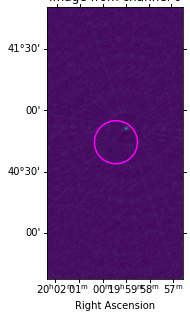

In [2]:
from sirius._sirius_utils._gen_utils import _display_image
_display_image(imname='simple.image',pbname='simple.pb',source_peak=2.17)